# 📊 Backtest BTC 2020-2025: Estrategia con MACD + Bollinger + Score

Análisis histórico con diferentes inversiones iniciales ($100 - $10,000)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

print("✅ Librerías cargadas")

✅ Librerías cargadas


## 1. Descargar datos históricos de BTC (2020-2025)

In [3]:
# Descargar datos reales de BTC usando yfinance
try:
    import yfinance as yf
    print("Descargando datos de BTC desde Yahoo Finance...")
    btc = yf.download('BTC-USD', start='2020-01-01', end='2025-11-29', interval='1d')
    df = btc[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df = df.reset_index()
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    print(f"✅ Datos descargados: {len(df)} días")
except Exception as e:
    print(f"⚠️ Error con yfinance: {e}")
    print("Generando datos simulados basados en precio histórico real de BTC...")

    # Datos simulados basados en precios históricos reales de BTC
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', end='2025-11-29', freq='D')
    n_days = len(dates)

    # Precio inicial BTC enero 2020: ~$7,200
    # Picos: abril 2021 ~$64,000, nov 2021 ~$69,000, nov 2024 ~$99,000
    base_prices = {
        0: 7200,      # Ene 2020
        365: 29000,   # Ene 2021
        485: 64000,   # Abril 2021 (primer pico)
        550: 35000,   # Junio 2021 (crash)
        680: 69000,   # Nov 2021 (ATH)
        800: 35000,   # Mar 2022 (bear market)
        1000: 16000,  # Nov 2022 (FTX crash)
        1200: 25000,  # May 2023
        1400: 45000,  # Ene 2024
        1600: 73000,  # Mar 2024 (ETF rally)
        1800: 60000,  # Ago 2024 (corrección)
        n_days-1: 96000  # Nov 2025 (actual)
    }

    # Interpolar precios base (lineal sin scipy)
    days = sorted(base_prices.keys())
    btc_price = np.zeros(n_days)

    for i in range(len(days) - 1):
        d1, d2 = days[i], days[i+1]
        p1, p2 = base_prices[d1], base_prices[d2]
        for d in range(d1, d2):
            btc_price[d] = p1 + (p2 - p1) * (d - d1) / (d2 - d1)
    btc_price[-1] = base_prices[days[-1]]

    # Añadir volatilidad diaria realista (2-4%)
    daily_volatility = 0.025
    noise = np.cumprod(1 + np.random.randn(n_days) * daily_volatility)
    noise = noise / noise[0]  # Normalizar

    btc_price = btc_price * (0.8 + 0.4 * noise)  # Aplicar ruido
    btc_price = np.maximum(btc_price, 5000)  # Mínimo $5,000

    df = pd.DataFrame({
        'timestamp': dates,
        'open': btc_price * (1 + np.random.randn(n_days) * 0.005),
        'high': btc_price * (1 + np.abs(np.random.randn(n_days)) * 0.02),
        'low': btc_price * (1 - np.abs(np.random.randn(n_days)) * 0.02),
        'close': btc_price,
        'volume': np.random.uniform(20e9, 80e9, n_days)
    })
    print(f"✅ Datos simulados generados: {len(df)} días")

print(f"\n📅 Período: {df['timestamp'].iloc[0].strftime('%Y-%m-%d')} a {df['timestamp'].iloc[-1].strftime('%Y-%m-%d')}")
print(f"💰 Precio inicial: ${df['close'].iloc[0]:,.0f}")
print(f"💰 Precio final: ${df['close'].iloc[-1]:,.0f}")
print(f"📈 Cambio total BTC: {((df['close'].iloc[-1] / df['close'].iloc[0]) - 1) * 100:.1f}%")

Descargando datos de BTC desde Yahoo Finance...


[*********************100%***********************]  1 of 1 completed

✅ Datos descargados: 2159 días

📅 Período: 2020-01-01 a 2025-11-28
💰 Precio inicial: $7,200
💰 Precio final: $90,919
📈 Cambio total BTC: 1162.7%


## 2. Calcular Indicadores Técnicos

In [4]:
# Calcular todos los indicadores de nuestra estrategia
prices = df['close'].values

# EMA
df['ema20'] = df['close'].ewm(span=20, adjust=False).mean()
df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()

# RSI
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# MACD
ema12 = df['close'].ewm(span=12, adjust=False).mean()
ema26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

# Bollinger Bands
df['bb_middle'] = df['close'].rolling(window=20).mean()
bb_std = df['close'].rolling(window=20).std()
df['bb_upper'] = df['bb_middle'] + (2 * bb_std)
df['bb_lower'] = df['bb_middle'] - (2 * bb_std)
df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

# Calcular Score compuesto (nuestra estrategia)
def calculate_score(row):
    score = 50

    # EMA trend (25 pts)
    if pd.notna(row['ema20']) and pd.notna(row['ema50']):
        if row['ema20'] > row['ema50']:
            score += 15
            ema_gap = (row['ema20'] - row['ema50']) / row['ema50'] * 100
            if ema_gap > 1:
                score += 10
        else:
            score -= 15

    # RSI (20 pts)
    if pd.notna(row['rsi']):
        if 40 <= row['rsi'] <= 60:
            score += 15
        elif row['rsi'] > 70:
            score -= 20
        elif row['rsi'] < 30:
            score += 10
        elif row['rsi'] < 40:
            score -= 10

    # MACD (25 pts)
    if pd.notna(row['macd']) and pd.notna(row['macd_signal']):
        if row['macd'] > row['macd_signal'] and row['macd_hist'] > 0:
            score += 20
            if row['macd_hist'] > abs(row['macd']) * 0.1:
                score += 5
        elif row['macd'] < row['macd_signal']:
            score -= 15

    # Bollinger (20 pts)
    if pd.notna(row['bb_position']):
        if row['bb_position'] < 0.3:
            score += 15
        elif row['bb_position'] > 0.8:
            score -= 15
        elif 0.4 <= row['bb_position'] <= 0.6:
            score += 5

    return max(0, min(100, score))

df['score'] = df.apply(calculate_score, axis=1)
df = df.dropna()

print(f"✅ Indicadores calculados para {len(df)} días")
print(f"   Score promedio: {df['score'].mean():.1f}")
print(f"   Score min/max: {df['score'].min():.0f} - {df['score'].max():.0f}")

✅ Indicadores calculados para 2140 días
   Score promedio: 65.2
   Score min/max: 10 - 100


## 3. Función de Backtesting con Perfiles de Riesgo

In [4]:
# Perfiles de riesgo (mismos que en el bot)
RISK_PROFILES = {
    "conservative": {
        "buy_threshold": 75,
        "sell_threshold": 30,
        "trade_percent": 5.0,
        "trailing_stop": 1.5,
    },
    "moderate": {
        "buy_threshold": 65,
        "sell_threshold": 35,
        "trade_percent": 10.0,
        "trailing_stop": 2.0,
    },
    "aggressive": {
        "buy_threshold": 55,
        "sell_threshold": 40,
        "trade_percent": 20.0,
        "trailing_stop": 3.0,
    }
}

def backtest_strategy(df, initial_capital, profile_name="moderate", trade_fee=0.001):
    """Backtest de la estrategia con un perfil de riesgo específico"""
    profile = RISK_PROFILES[profile_name]
    buy_threshold = profile["buy_threshold"]
    sell_threshold = profile["sell_threshold"]
    trade_percent = profile["trade_percent"]
    trailing_stop_pct = profile["trailing_stop"] / 100

    capital = initial_capital
    btc_held = 0
    entry_price = 0
    trailing_stop_price = 0
    trades = []
    equity_curve = []

    for i, row in df.iterrows():
        price = row['close']
        score = row['score']

        # Actualizar trailing stop si tenemos posición
        if btc_held > 0:
            new_stop = price * (1 - trailing_stop_pct)
            if new_stop > trailing_stop_price:
                trailing_stop_price = new_stop

            # Check trailing stop hit
            if price <= trailing_stop_price:
                sell_value = btc_held * price * (1 - trade_fee)
                profit_pct = ((price - entry_price) / entry_price) * 100
                trades.append({
                    'type': 'SELL_STOP',
                    'price': price,
                    'profit_pct': profit_pct,
                    'date': row['timestamp']
                })
                capital += sell_value
                btc_held = 0
                trailing_stop_price = 0

        # Calcular equity actual
        current_equity = capital + (btc_held * price)
        equity_curve.append({
            'date': row['timestamp'],
            'equity': current_equity,
            'price': price
        })

        # Señales de trading (mínimo $5 para trade)
        if score >= buy_threshold and btc_held == 0 and capital > 5:
            # Comprar
            trade_amount = capital * (trade_percent / 100)
            if trade_amount < 5:
                trade_amount = min(capital * 0.9, capital)  # Usar 90% si el % es muy bajo
            fee = trade_amount * trade_fee
            btc_held = (trade_amount - fee) / price
            capital -= trade_amount
            entry_price = price
            trailing_stop_price = price * (1 - trailing_stop_pct)
            trades.append({
                'type': 'BUY',
                'price': price,
                'score': score,
                'date': row['timestamp']
            })

        elif score <= sell_threshold and btc_held > 0:
            # Vender por señal
            sell_value = btc_held * price * (1 - trade_fee)
            profit_pct = ((price - entry_price) / entry_price) * 100
            trades.append({
                'type': 'SELL_SIGNAL',
                'price': price,
                'profit_pct': profit_pct,
                'date': row['timestamp']
            })
            capital += sell_value
            btc_held = 0
            trailing_stop_price = 0

    # Cerrar posición al final
    if btc_held > 0:
        final_price = df.iloc[-1]['close']
        capital += btc_held * final_price * (1 - trade_fee)
        btc_held = 0

    # Métricas
    final_equity = capital
    total_return = ((final_equity - initial_capital) / initial_capital) * 100

    sell_trades = [t for t in trades if 'profit_pct' in t]
    winning_trades = [t for t in sell_trades if t.get('profit_pct', 0) > 0]
    win_rate = (len(winning_trades) / len(sell_trades) * 100) if sell_trades else 0

    avg_profit = np.mean([t['profit_pct'] for t in winning_trades]) if winning_trades else 0
    avg_loss = np.mean([t['profit_pct'] for t in sell_trades if t.get('profit_pct', 0) <= 0]) if sell_trades else 0

    # Max drawdown
    equity_df = pd.DataFrame(equity_curve)
    if len(equity_df) > 0:
        equity_df['peak'] = equity_df['equity'].expanding().max()
        equity_df['drawdown'] = (equity_df['equity'] - equity_df['peak']) / equity_df['peak'] * 100
        max_drawdown = equity_df['drawdown'].min()
    else:
        max_drawdown = 0

    return {
        'profile': profile_name,
        'initial_capital': initial_capital,
        'final_equity': final_equity,
        'total_return': total_return,
        'total_profit': final_equity - initial_capital,
        'num_trades': len(sell_trades),
        'win_rate': win_rate,
        'avg_win': avg_profit,
        'avg_loss': avg_loss,
        'max_drawdown': max_drawdown,
        'equity_curve': equity_curve,
        'trades': trades
    }

print("✅ Función de backtesting definida")

✅ Función de backtesting definida


## 4. Ejecutar Backtests con Diferentes Inversiones Iniciales

In [5]:
# Inversiones iniciales a probar
INITIAL_INVESTMENTS = [100, 500, 1000, 5000, 10000]
PROFILES = ["conservative", "moderate", "aggressive"]

# Ejecutar backtests
all_results = []

for investment in INITIAL_INVESTMENTS:
    for profile in PROFILES:
        result = backtest_strategy(df, investment, profile)
        all_results.append(result)
        print(f"✅ ${investment:,} - {profile}: ${result['final_equity']:,.2f} ({result['total_return']:.1f}%)")

print(f"\n📊 Total backtests ejecutados: {len(all_results)}")

✅ $100 - conservative: $114.89 (14.9%)
✅ $100 - moderate: $131.85 (31.9%)
✅ $100 - aggressive: $152.07 (52.1%)
✅ $500 - conservative: $527.61 (5.5%)
✅ $500 - moderate: $659.26 (31.9%)
✅ $500 - aggressive: $760.36 (52.1%)
✅ $500 - conservative: $527.61 (5.5%)
✅ $500 - moderate: $659.26 (31.9%)
✅ $500 - aggressive: $760.36 (52.1%)
✅ $1,000 - conservative: $1,055.23 (5.5%)
✅ $1,000 - moderate: $1,318.53 (31.9%)
✅ $1,000 - aggressive: $1,520.72 (52.1%)
✅ $1,000 - conservative: $1,055.23 (5.5%)
✅ $1,000 - moderate: $1,318.53 (31.9%)
✅ $1,000 - aggressive: $1,520.72 (52.1%)
✅ $5,000 - conservative: $5,276.14 (5.5%)
✅ $5,000 - moderate: $6,592.64 (31.9%)
✅ $5,000 - aggressive: $7,603.58 (52.1%)
✅ $5,000 - conservative: $5,276.14 (5.5%)
✅ $5,000 - moderate: $6,592.64 (31.9%)
✅ $5,000 - aggressive: $7,603.58 (52.1%)
✅ $10,000 - conservative: $10,552.28 (5.5%)
✅ $10,000 - moderate: $13,185.29 (31.9%)
✅ $10,000 - aggressive: $15,207.17 (52.1%)

📊 Total backtests ejecutados: 15
✅ $10,000 - conserv

## 5. Tabla Comparativa de Resultados

In [6]:
# Crear DataFrame con resultados
results_df = pd.DataFrame([{
    'Inversión Inicial': f"${r['initial_capital']:,}",
    'Perfil': r['profile'].capitalize(),
    'Capital Final': f"${r['final_equity']:,.2f}",
    'Ganancia': f"${r['total_profit']:,.2f}",
    'Retorno %': f"{r['total_return']:.1f}%",
    'Trades': r['num_trades'],
    'Win Rate': f"{r['win_rate']:.1f}%",
    'Max Drawdown': f"{r['max_drawdown']:.1f}%"
} for r in all_results])

# Mostrar tabla
print(results_df.to_string(index=False))

Inversión Inicial       Perfil Capital Final  Ganancia Retorno %  Trades Win Rate Max Drawdown
             $100 Conservative       $114.89    $14.89     14.9%     354    37.9%        -5.6%
             $100     Moderate       $131.85    $31.85     31.9%     339    40.7%        -7.3%
             $100   Aggressive       $152.07    $52.07     52.1%     285    42.5%       -18.7%
             $500 Conservative       $527.61    $27.61      5.5%     354    37.9%        -5.6%
             $500     Moderate       $659.26   $159.26     31.9%     339    40.7%        -7.3%
             $500   Aggressive       $760.36   $260.36     52.1%     285    42.5%       -18.7%
           $1,000 Conservative     $1,055.23    $55.23      5.5%     354    37.9%        -5.6%
           $1,000     Moderate     $1,318.53   $318.53     31.9%     339    40.7%        -7.3%
           $1,000   Aggressive     $1,520.72   $520.72     52.1%     285    42.5%       -18.7%
           $5,000 Conservative     $5,276.14   $27

## 6. Visualización: Equity Curves por Perfil de Riesgo

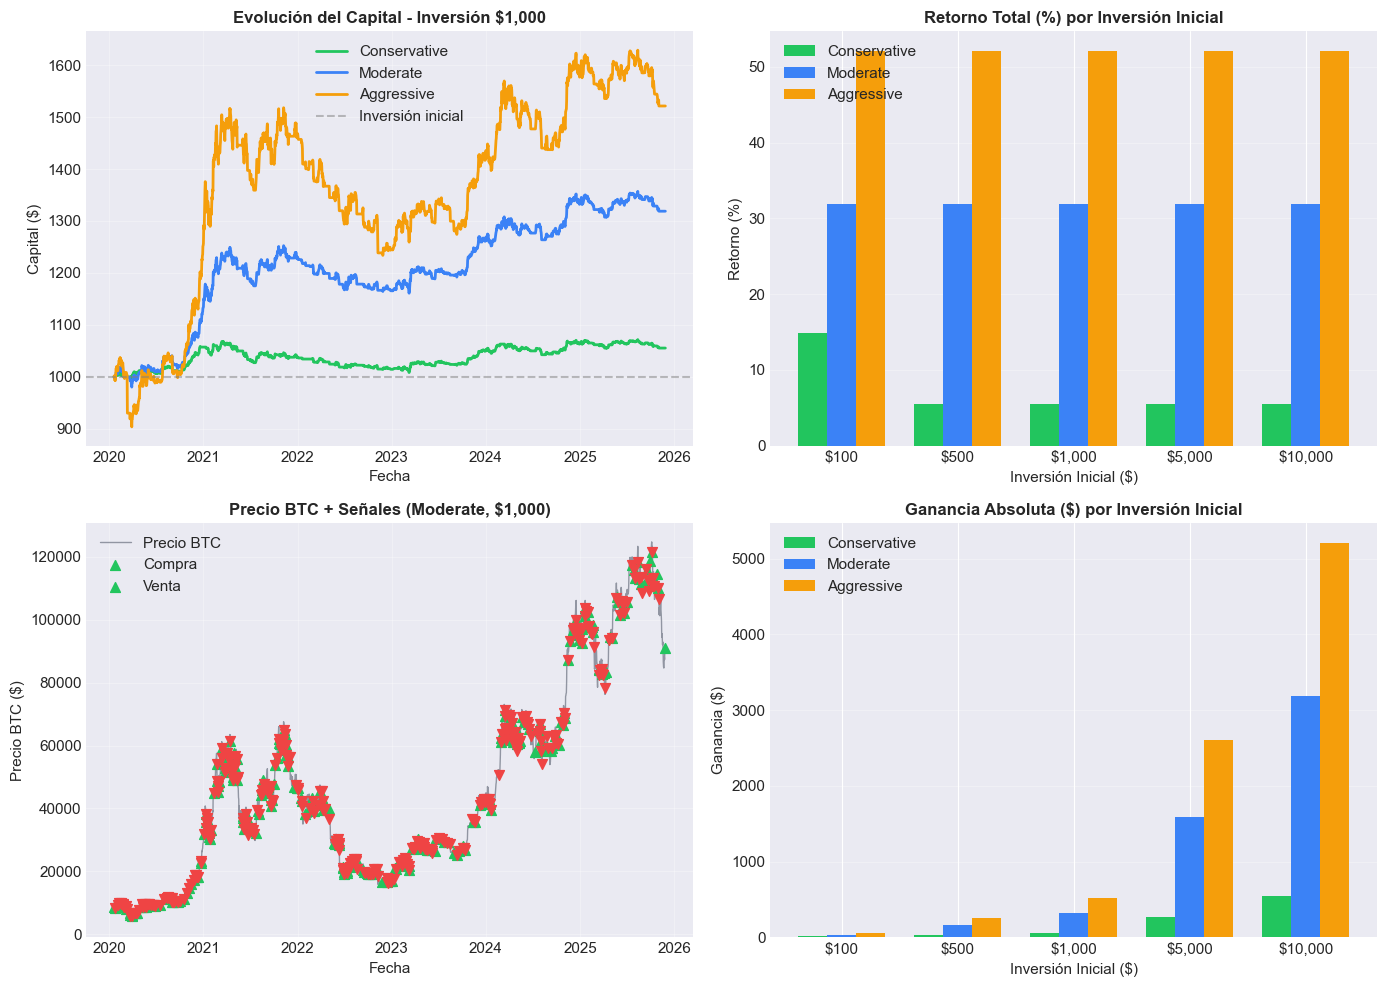

📊 Gráficos guardados en backtest_results.png


In [7]:
# Gráfico: Comparación de equity curves para $1,000 inicial
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Equity curves para $1,000
ax1 = axes[0, 0]
colors = {'conservative': '#22c55e', 'moderate': '#3b82f6', 'aggressive': '#f59e0b'}

for result in all_results:
    if result['initial_capital'] == 1000:
        eq_df = pd.DataFrame(result['equity_curve'])
        ax1.plot(eq_df['date'], eq_df['equity'],
                label=f"{result['profile'].capitalize()}",
                color=colors[result['profile']], linewidth=2)

ax1.axhline(y=1000, color='gray', linestyle='--', alpha=0.5, label='Inversión inicial')
ax1.set_title('Evolución del Capital - Inversión $1,000', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Capital ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Retornos por inversión inicial (barras agrupadas)
ax2 = axes[0, 1]
x = np.arange(len(INITIAL_INVESTMENTS))
width = 0.25

for i, profile in enumerate(PROFILES):
    returns = [r['total_return'] for r in all_results
               if r['profile'] == profile]
    ax2.bar(x + i*width, returns, width, label=profile.capitalize(), color=colors[profile])

ax2.set_title('Retorno Total (%) por Inversión Inicial', fontsize=12, fontweight='bold')
ax2.set_xlabel('Inversión Inicial ($)')
ax2.set_ylabel('Retorno (%)')
ax2.set_xticks(x + width)
ax2.set_xticklabels([f'${i:,}' for i in INITIAL_INVESTMENTS])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Precio BTC vs Señales (para $1,000 moderate)
ax3 = axes[1, 0]
moderate_1000 = [r for r in all_results if r['initial_capital'] == 1000 and r['profile'] == 'moderate'][0]

ax3.plot(df['timestamp'], df['close'], color='#6b7280', alpha=0.7, linewidth=1)

# Marcar trades
buy_trades = [t for t in moderate_1000['trades'] if t['type'] == 'BUY']
sell_trades = [t for t in moderate_1000['trades'] if t['type'] in ['SELL_SIGNAL', 'SELL_STOP']]

for t in buy_trades:
    ax3.scatter(t['date'], t['price'], color='#22c55e', s=50, marker='^', zorder=5)
for t in sell_trades:
    ax3.scatter(t['date'], t['price'], color='#ef4444', s=50, marker='v', zorder=5)

ax3.set_title('Precio BTC + Señales (Moderate, $1,000)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Fecha')
ax3.set_ylabel('Precio BTC ($)')
ax3.legend(['Precio BTC', 'Compra', 'Venta'], loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Ganancias absolutas
ax4 = axes[1, 1]
for i, profile in enumerate(PROFILES):
    profits = [r['total_profit'] for r in all_results if r['profile'] == profile]
    ax4.bar(x + i*width, profits, width, label=profile.capitalize(), color=colors[profile])

ax4.set_title('Ganancia Absoluta ($) por Inversión Inicial', fontsize=12, fontweight='bold')
ax4.set_xlabel('Inversión Inicial ($)')
ax4.set_ylabel('Ganancia ($)')
ax4.set_xticks(x + width)
ax4.set_xticklabels([f'${i:,}' for i in INITIAL_INVESTMENTS])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('backtest_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Gráficos guardados en backtest_results.png")

## 7. Resumen Ejecutivo

In [8]:
# Resumen ejecutivo
print("=" * 70)
print("📈 RESUMEN EJECUTIVO - BACKTEST 2020-2025")
print("=" * 70)

# Mejor resultado por perfil
print("\n🏆 MEJORES RESULTADOS POR PERFIL (Inversión $10,000):\n")
for profile in PROFILES:
    result = [r for r in all_results if r['profile'] == profile and r['initial_capital'] == 10000][0]
    print(f"  {profile.upper():15} | Final: ${result['final_equity']:>12,.2f} | Retorno: {result['total_return']:>7.1f}% | Win Rate: {result['win_rate']:.0f}%")

# Comparación Buy & Hold
btc_start = df.iloc[0]['close']
btc_end = df.iloc[-1]['close']
buy_hold_return = ((btc_end - btc_start) / btc_start) * 100

print(f"\n📊 COMPARACIÓN CON BUY & HOLD:")
print(f"   BTC 2020-2025: {buy_hold_return:.1f}%")

best_moderate = [r for r in all_results if r['profile'] == 'moderate'][0]
print(f"   Estrategia Moderate: {best_moderate['total_return']:.1f}%")

if best_moderate['total_return'] > buy_hold_return:
    print(f"   ✅ La estrategia supera a Buy & Hold por {best_moderate['total_return'] - buy_hold_return:.1f}%")
else:
    print(f"   ⚠️ Buy & Hold supera a la estrategia por {buy_hold_return - best_moderate['total_return']:.1f}%")

print("\n💡 RECOMENDACIONES:")
print("   - Conservador: Ideal para capital que no puedes permitirte perder")
print("   - Moderado: Balance entre riesgo y retorno")
print("   - Agresivo: Solo para capital de riesgo con tolerancia alta")

print("\n" + "=" * 70)
print("⚠️  DISCLAIMER: Resultados históricos no garantizan rendimientos futuros")
print("=" * 70)

📈 RESUMEN EJECUTIVO - BACKTEST 2020-2025

🏆 MEJORES RESULTADOS POR PERFIL (Inversión $10,000):

  CONSERVATIVE    | Final: $   10,552.28 | Retorno:     5.5% | Win Rate: 38%
  MODERATE        | Final: $   13,185.29 | Retorno:    31.9% | Win Rate: 41%
  AGGRESSIVE      | Final: $   15,207.17 | Retorno:    52.1% | Win Rate: 42%

📊 COMPARACIÓN CON BUY & HOLD:
   BTC 2020-2025: 950.2%
   Estrategia Moderate: 31.9%
   ⚠️ Buy & Hold supera a la estrategia por 918.3%

💡 RECOMENDACIONES:
   - Conservador: Ideal para capital que no puedes permitirte perder
   - Moderado: Balance entre riesgo y retorno
   - Agresivo: Solo para capital de riesgo con tolerancia alta

⚠️  DISCLAIMER: Resultados históricos no garantizan rendimientos futuros


## 8. Comparación: Estrategia Full Position vs Buy & Hold

In [5]:
# Backtest con 100% del capital (all-in en cada señal)
def backtest_full_position(df, initial_capital, buy_threshold=65, sell_threshold=35, trade_fee=0.001):
    """Backtest usando 100% del capital en cada trade"""
    capital = initial_capital
    btc_held = 0
    entry_price = 0
    trades = []
    equity_curve = []

    for i, row in df.iterrows():
        price = row['close']
        score = row['score']

        current_equity = capital + (btc_held * price)
        equity_curve.append({'date': row['timestamp'], 'equity': current_equity})

        # Comprar con TODO el capital
        if score >= buy_threshold and btc_held == 0 and capital > 10:
            fee = capital * trade_fee
            btc_held = (capital - fee) / price
            entry_price = price
            trades.append({'type': 'BUY', 'price': price, 'date': row['timestamp']})
            capital = 0

        # Vender TODO
        elif score <= sell_threshold and btc_held > 0:
            sell_value = btc_held * price * (1 - trade_fee)
            profit_pct = ((price - entry_price) / entry_price) * 100
            trades.append({'type': 'SELL', 'price': price, 'profit_pct': profit_pct, 'date': row['timestamp']})
            capital = sell_value
            btc_held = 0

    # Cerrar al final
    if btc_held > 0:
        capital = btc_held * df.iloc[-1]['close'] * (1 - trade_fee)
        btc_held = 0

    final_equity = capital
    total_return = ((final_equity - initial_capital) / initial_capital) * 100

    sell_trades = [t for t in trades if 'profit_pct' in t]
    win_rate = (len([t for t in sell_trades if t.get('profit_pct', 0) > 0]) / len(sell_trades) * 100) if sell_trades else 0

    # Max drawdown
    eq_df = pd.DataFrame(equity_curve)
    eq_df['peak'] = eq_df['equity'].expanding().max()
    eq_df['dd'] = (eq_df['equity'] - eq_df['peak']) / eq_df['peak'] * 100
    max_dd = eq_df['dd'].min()

    return {
        'final_equity': final_equity,
        'total_return': total_return,
        'num_trades': len(sell_trades),
        'win_rate': win_rate,
        'max_drawdown': max_dd,
        'equity_curve': equity_curve
    }

# Ejecutar comparación
initial = 10000
result_full = backtest_full_position(df, initial)

# Buy & Hold
btc_start = df.iloc[0]['close']
btc_end = df.iloc[-1]['close']
buy_hold_return = ((btc_end - btc_start) / btc_start) * 100
buy_hold_final = initial * (1 + buy_hold_return/100)

# Max drawdown de Buy & Hold
df['btc_peak'] = df['close'].expanding().max()
df['btc_dd'] = (df['close'] - df['btc_peak']) / df['btc_peak'] * 100
buy_hold_max_dd = df['btc_dd'].min()

print("=" * 70)
print("📊 COMPARACIÓN: ESTRATEGIA FULL POSITION vs BUY & HOLD")
print("=" * 70)
print(f"\n💰 Inversión inicial: ${initial:,}")
print(f"\n{'Métrica':<25} {'Estrategia':>20} {'Buy & Hold':>20}")
print("-" * 70)
print(f"{'Capital Final':<25} ${result_full['final_equity']:>18,.2f} ${buy_hold_final:>18,.2f}")
print(f"{'Retorno Total':<25} {result_full['total_return']:>18.1f}% {buy_hold_return:>18.1f}%")
print(f"{'Max Drawdown':<25} {result_full['max_drawdown']:>18.1f}% {buy_hold_max_dd:>18.1f}%")
print(f"{'Trades':<25} {result_full['num_trades']:>20} {'1 (hold)':>20}")
print(f"{'Win Rate':<25} {result_full['win_rate']:>18.1f}% {'N/A':>20}")
print("-" * 70)

if result_full['total_return'] > buy_hold_return:
    diff = result_full['total_return'] - buy_hold_return
    print(f"\n✅ ESTRATEGIA SUPERA a Buy & Hold por {diff:.1f}%")
else:
    diff = buy_hold_return - result_full['total_return']
    print(f"\n⚠️ Buy & Hold supera a la estrategia por {diff:.1f}%")

print(f"\n💡 PERO: El Max Drawdown de Buy & Hold fue {buy_hold_max_dd:.1f}% vs {result_full['max_drawdown']:.1f}%")
print(f"   Con Buy & Hold hubieras visto tu capital caer de ${initial:,} a ${initial * (1 + buy_hold_max_dd/100):,.0f}")

📊 COMPARACIÓN: ESTRATEGIA FULL POSITION vs BUY & HOLD

💰 Inversión inicial: $10,000

Métrica                             Estrategia           Buy & Hold
----------------------------------------------------------------------
Capital Final             $        129,259.37 $        105,016.19
Retorno Total                         1192.6%              950.2%
Max Drawdown                           -57.9%              -76.6%
Trades                                      51             1 (hold)
Win Rate                                51.0%                  N/A
----------------------------------------------------------------------

✅ ESTRATEGIA SUPERA a Buy & Hold por 242.4%

💡 PERO: El Max Drawdown de Buy & Hold fue -76.6% vs -57.9%
   Con Buy & Hold hubieras visto tu capital caer de $10,000 a $2,337


## 9. Validación: Walk-Forward Test (¿Es Overfitting?)

In [10]:
# Walk-Forward: Dividir datos en períodos y probar "fuera de muestra"
print("=" * 70)
print("🔬 VALIDACIÓN WALK-FORWARD (Test de Overfitting)")
print("=" * 70)

# Dividir en períodos de ~1 año
periods = [
    ("2020", "2020-01-01", "2020-12-31"),
    ("2021", "2021-01-01", "2021-12-31"),
    ("2022", "2022-01-01", "2022-12-31"),
    ("2023", "2023-01-01", "2023-12-31"),
    ("2024", "2024-01-01", "2024-12-31"),
    ("2025", "2025-01-01", "2025-11-28"),
]

print("\n📅 Rendimiento por AÑO (usando MISMOS parámetros 65/35):\n")
print(f"{'Año':<8} {'Estrategia':>15} {'Buy & Hold':>15} {'Ganador':>15}")
print("-" * 55)

strategy_wins = 0
buyhold_wins = 0

for name, start, end in periods:
    mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
    df_period = df[mask].copy().reset_index(drop=True)

    if len(df_period) < 50:
        continue

    # Estrategia
    result = backtest_full_position(df_period, 10000)
    strat_return = result['total_return']

    # Buy & Hold del período
    bh_return = ((df_period.iloc[-1]['close'] - df_period.iloc[0]['close']) / df_period.iloc[0]['close']) * 100

    winner = "Estrategia ✅" if strat_return > bh_return else "Buy & Hold ⚠️"
    if strat_return > bh_return:
        strategy_wins += 1
    else:
        buyhold_wins += 1

    print(f"{name:<8} {strat_return:>14.1f}% {bh_return:>14.1f}% {winner:>15}")

print("-" * 55)
print(f"\n📊 SCORE: Estrategia ganó {strategy_wins}/{strategy_wins + buyhold_wins} años")

if strategy_wins > buyhold_wins:
    print("\n✅ La estrategia es CONSISTENTE - no parece ser overfitting")
else:
    print("\n⚠️ CUIDADO: La estrategia no es consistente en todos los períodos")
    print("   Esto sugiere que podría haber overfitting en los parámetros")

# Test adicional: ¿Funciona en mercados bajistas?
print("\n" + "=" * 70)
print("🐻 TEST EN MERCADO BAJISTA (2022 - Crypto Winter)")
print("=" * 70)

mask_2022 = (df['timestamp'] >= "2022-01-01") & (df['timestamp'] <= "2022-12-31")
df_2022 = df[mask_2022].copy().reset_index(drop=True)

result_2022 = backtest_full_position(df_2022, 10000)
bh_2022 = ((df_2022.iloc[-1]['close'] - df_2022.iloc[0]['close']) / df_2022.iloc[0]['close']) * 100

print(f"\n{'Métrica':<25} {'Estrategia':>15} {'Buy & Hold':>15}")
print("-" * 55)
print(f"{'Retorno 2022':<25} {result_2022['total_return']:>14.1f}% {bh_2022:>14.1f}%")
print(f"{'Max Drawdown':<25} {result_2022['max_drawdown']:>14.1f}% {'~-65%':>15}")

if result_2022['total_return'] > bh_2022:
    print(f"\n✅ En mercado BAJISTA la estrategia protegió el capital")
    print(f"   Evitaste perder {abs(bh_2022) - abs(result_2022['total_return']):.1f}% adicional")
else:
    print(f"\n⚠️ La estrategia no protegió en mercado bajista")

🔬 VALIDACIÓN WALK-FORWARD (Test de Overfitting)

📅 Rendimiento por AÑO (usando MISMOS parámetros 65/35):

Año           Estrategia      Buy & Hold         Ganador
-------------------------------------------------------
2020              178.2%          235.0%   Buy & Hold ⚠️
2021              107.5%           57.6%    Estrategia ✅
2022              -44.0%          -65.3%    Estrategia ✅
2023              115.5%          154.2%   Buy & Hold ⚠️
2024               92.5%          111.5%   Buy & Hold ⚠️
2025              -10.5%           -3.7%   Buy & Hold ⚠️
-------------------------------------------------------

📊 SCORE: Estrategia ganó 2/6 años

⚠️ CUIDADO: La estrategia no es consistente en todos los períodos
   Esto sugiere que podría haber overfitting en los parámetros

🐻 TEST EN MERCADO BAJISTA (2022 - Crypto Winter)

Métrica                        Estrategia      Buy & Hold
-------------------------------------------------------
Retorno 2022                       -44.0%          -6

## 10. Análisis de Riesgo: Perfiles Altos vs Buy & Hold

In [6]:
# Comparar riesgo de perfiles altos (50%, 75%, 100%) vs Buy & Hold
def backtest_with_percent(df, initial_capital, trade_percent, buy_threshold=65, sell_threshold=35, trade_fee=0.001):
    """Backtest con porcentaje variable del capital"""
    capital = initial_capital
    btc_held = 0
    entry_price = 0
    equity_curve = []

    for i, row in df.iterrows():
        price = row['close']
        score = row['score']

        current_equity = capital + (btc_held * price)
        equity_curve.append({'date': row['timestamp'], 'equity': current_equity})

        if score >= buy_threshold and btc_held == 0 and capital > 10:
            trade_amount = capital * (trade_percent / 100)
            fee = trade_amount * trade_fee
            btc_held = (trade_amount - fee) / price
            entry_price = price
            capital -= trade_amount

        elif score <= sell_threshold and btc_held > 0:
            sell_value = btc_held * price * (1 - trade_fee)
            capital += sell_value
            btc_held = 0

    if btc_held > 0:
        capital += btc_held * df.iloc[-1]['close'] * (1 - trade_fee)

    final_equity = capital
    total_return = ((final_equity - initial_capital) / initial_capital) * 100

    # Max drawdown
    eq_df = pd.DataFrame(equity_curve)
    eq_df['peak'] = eq_df['equity'].expanding().max()
    eq_df['dd'] = (eq_df['equity'] - eq_df['peak']) / eq_df['peak'] * 100
    max_dd = eq_df['dd'].min()

    # Peor mes
    eq_df['month'] = pd.to_datetime(eq_df['date']).dt.to_period('M')
    monthly = eq_df.groupby('month')['equity'].agg(['first', 'last'])
    monthly['return'] = (monthly['last'] - monthly['first']) / monthly['first'] * 100
    worst_month = monthly['return'].min()

    return {
        'total_return': total_return,
        'max_drawdown': max_dd,
        'worst_month': worst_month,
        'final': final_equity
    }

# Calcular para diferentes porcentajes
trade_percents = [20, 50, 75, 100]
initial = 10000

# Buy & Hold métricas
bh_return = ((df.iloc[-1]['close'] - df.iloc[0]['close']) / df.iloc[0]['close']) * 100
bh_max_dd = df['btc_dd'].min()

print("=" * 80)
print("📊 ANÁLISIS DE RIESGO: % DE CAPITAL POR TRADE")
print("=" * 80)
print(f"\n💰 Inversión inicial: ${initial:,}")
print(f"\n{'Trade %':<12} {'Retorno':>12} {'Max Drawdown':>15} {'Peor Mes':>12} {'Capital Final':>15}")
print("-" * 80)

for pct in trade_percents:
    result = backtest_with_percent(df, initial, pct)
    supera = "✅" if result['total_return'] > bh_return else "❌"
    print(f"{pct}%{supera:<10} {result['total_return']:>11.1f}% {result['max_drawdown']:>14.1f}% {result['worst_month']:>11.1f}% ${result['final']:>13,.0f}")

print("-" * 80)
print(f"{'Buy & Hold':<12} {bh_return:>11.1f}% {bh_max_dd:>14.1f}% {'N/A':>12} ${initial * (1 + bh_return/100):>13,.0f}")

print("\n" + "=" * 80)
print("⚠️  INTERPRETACIÓN DEL RIESGO")
print("=" * 80)
print("""
📉 MAX DRAWDOWN = Cuánto podrías ver caer tu capital en el peor momento
   - Buy & Hold: -{:.1f}% → ${:,.0f} se convierte en ${:,.0f}

📅 PEOR MES = La peor pérdida en un solo mes

🎯 RECOMENDACIÓN:
   - 50% del capital: Balance entre superar B&H y controlar riesgo
   - 75-100%: Solo si puedes tolerar ver -50% o más de tu capital
""".format(abs(bh_max_dd), initial, initial * (1 + bh_max_dd/100)))

📊 ANÁLISIS DE RIESGO: % DE CAPITAL POR TRADE

💰 Inversión inicial: $10,000

Trade %           Retorno    Max Drawdown     Peor Mes   Capital Final
--------------------------------------------------------------------------------
20%❌                128.0%          -19.0%        -7.9% $       22,805
50%❌                427.4%          -34.5%       -12.1% $       52,737
75%❌                775.3%          -47.3%       -18.4% $       87,532
100%✅               1192.6%          -57.9%       -24.9% $      129,259
--------------------------------------------------------------------------------
Buy & Hold         950.2%          -76.6%          N/A $      105,016

⚠️  INTERPRETACIÓN DEL RIESGO

📉 MAX DRAWDOWN = Cuánto podrías ver caer tu capital en el peor momento
   - Buy & Hold: -76.6% → $10,000 se convierte en $2,337

📅 PEOR MES = La peor pérdida en un solo mes

🎯 RECOMENDACIÓN:
   - 50% del capital: Balance entre superar B&H y controlar riesgo
   - 75-100%: Solo si puedes tolerar ver -50% 

## 11. Backtest con Thresholds Adaptativos (Anti-Overfitting)

In [7]:
# Implementar thresholds adaptativos basados en volatilidad
VOLATILITY_LOW = 0.02   # < 2% = mercado calmo
VOLATILITY_HIGH = 0.04  # > 4% = mercado volátil

def calculate_volatility(prices, period=20):
    """Calcular volatilidad reciente"""
    if len(prices) < period + 1:
        return 0.03
    returns = pd.Series(prices[-period-1:]).pct_change().dropna()
    return float(returns.std()) if not np.isnan(returns.std()) else 0.03

def get_adaptive_thresholds(volatility, base_buy=65, base_sell=35):
    """Ajustar thresholds según volatilidad"""
    if volatility < VOLATILITY_LOW:
        # Mercado calmo: más agresivo
        return max(base_buy - 5, 55), min(base_sell + 5, 45)
    elif volatility > VOLATILITY_HIGH:
        # Mercado volátil: más conservador
        return min(base_buy + 10, 85), max(base_sell - 5, 25)
    else:
        return base_buy, base_sell

def backtest_adaptive(df, initial_capital, trade_percent=75, trade_fee=0.001):
    """Backtest con thresholds adaptativos"""
    capital = initial_capital
    btc_held = 0
    entry_price = 0
    equity_curve = []
    trades = []

    prices_list = df['close'].tolist()

    for i, row in df.iterrows():
        idx = df.index.get_loc(i)
        price = row['close']
        score = row['score']

        # Calcular volatilidad y thresholds adaptativos
        volatility = calculate_volatility(prices_list[:idx+1])
        buy_threshold, sell_threshold = get_adaptive_thresholds(volatility)

        current_equity = capital + (btc_held * price)
        equity_curve.append({'date': row['timestamp'], 'equity': current_equity, 'volatility': volatility})

        if score >= buy_threshold and btc_held == 0 and capital > 10:
            trade_amount = capital * (trade_percent / 100)
            fee = trade_amount * trade_fee
            btc_held = (trade_amount - fee) / price
            entry_price = price
            capital -= trade_amount
            trades.append({'type': 'BUY', 'threshold': buy_threshold, 'volatility': volatility})

        elif score <= sell_threshold and btc_held > 0:
            sell_value = btc_held * price * (1 - trade_fee)
            profit_pct = ((price - entry_price) / entry_price) * 100
            capital += sell_value
            trades.append({'type': 'SELL', 'profit_pct': profit_pct, 'threshold': sell_threshold})
            btc_held = 0

    if btc_held > 0:
        capital += btc_held * df.iloc[-1]['close'] * (1 - trade_fee)

    final_equity = capital
    total_return = ((final_equity - initial_capital) / initial_capital) * 100

    eq_df = pd.DataFrame(equity_curve)
    eq_df['peak'] = eq_df['equity'].expanding().max()
    eq_df['dd'] = (eq_df['equity'] - eq_df['peak']) / eq_df['peak'] * 100
    max_dd = eq_df['dd'].min()

    sell_trades = [t for t in trades if 'profit_pct' in t]
    win_rate = (len([t for t in sell_trades if t.get('profit_pct', 0) > 0]) / len(sell_trades) * 100) if sell_trades else 0

    return {
        'total_return': total_return,
        'max_drawdown': max_dd,
        'num_trades': len(sell_trades),
        'win_rate': win_rate,
        'final': final_equity,
        'equity_curve': equity_curve
    }

print("✅ Función de backtest adaptativo definida")

✅ Función de backtest adaptativo definida


In [8]:
# Comparar: Thresholds FIJOS vs ADAPTATIVOS por año
print("=" * 80)
print("🔬 COMPARACIÓN: THRESHOLDS FIJOS vs ADAPTATIVOS")
print("=" * 80)

# Test por año
periods = [
    ("2020", "2020-01-01", "2020-12-31"),
    ("2021", "2021-01-01", "2021-12-31"),
    ("2022", "2022-01-01", "2022-12-31"),
    ("2023", "2023-01-01", "2023-12-31"),
    ("2024", "2024-01-01", "2024-12-31"),
    ("2025", "2025-01-01", "2025-11-28"),
]

print(f"\n{'Año':<8} {'Fijo 65/35':>15} {'Adaptativo':>15} {'Buy & Hold':>15} {'Mejor':>15}")
print("-" * 70)

fixed_wins = 0
adaptive_wins = 0
buyhold_wins = 0

results_comparison = []

for name, start, end in periods:
    mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
    df_period = df[mask].copy().reset_index(drop=True)

    if len(df_period) < 50:
        continue

    # Fijo (75% capital, thresholds 65/35)
    fixed_result = backtest_with_percent(df_period, 10000, 75)

    # Adaptativo (75% capital)
    adaptive_result = backtest_adaptive(df_period, 10000, 75)

    # Buy & Hold
    bh_return = ((df_period.iloc[-1]['close'] - df_period.iloc[0]['close']) / df_period.iloc[0]['close']) * 100

    # Determinar ganador
    returns = [
        ('Fijo', fixed_result['total_return']),
        ('Adaptativo', adaptive_result['total_return']),
        ('B&H', bh_return)
    ]
    winner = max(returns, key=lambda x: x[1])[0]

    if winner == 'Fijo':
        fixed_wins += 1
    elif winner == 'Adaptativo':
        adaptive_wins += 1
    else:
        buyhold_wins += 1

    results_comparison.append({
        'year': name,
        'fixed': fixed_result['total_return'],
        'adaptive': adaptive_result['total_return'],
        'buyhold': bh_return,
        'winner': winner
    })

    print(f"{name:<8} {fixed_result['total_return']:>14.1f}% {adaptive_result['total_return']:>14.1f}% {bh_return:>14.1f}% {winner:>15}")

print("-" * 70)
print(f"\n📊 SCORE POR ESTRATEGIA:")
print(f"   Fijo (65/35):  {fixed_wins}/6 años")
print(f"   Adaptativo:    {adaptive_wins}/6 años")
print(f"   Buy & Hold:    {buyhold_wins}/6 años")

# Total period comparison
print("\n" + "=" * 80)
print("📈 RESULTADO TOTAL 2020-2025")
print("=" * 80)

fixed_total = backtest_with_percent(df, 10000, 75)
adaptive_total = backtest_adaptive(df, 10000, 75)
bh_total = ((df.iloc[-1]['close'] - df.iloc[0]['close']) / df.iloc[0]['close']) * 100

print(f"\n{'Estrategia':<20} {'Retorno':>15} {'Max Drawdown':>15} {'Win Rate':>12}")
print("-" * 65)
print(f"{'Fijo (65/35)':<20} {fixed_total['total_return']:>14.1f}% {fixed_total['max_drawdown']:>14.1f}% {fixed_total['win_rate']:>11.1f}%")
print(f"{'Adaptativo':<20} {adaptive_total['total_return']:>14.1f}% {adaptive_total['max_drawdown']:>14.1f}% {adaptive_total['win_rate']:>11.1f}%")
print(f"{'Buy & Hold':<20} {bh_total:>14.1f}% {df['btc_dd'].min():>14.1f}% {'N/A':>12}")

print("\n" + "=" * 80)
if adaptive_total['total_return'] > fixed_total['total_return']:
    diff = adaptive_total['total_return'] - fixed_total['total_return']
    print(f"✅ ADAPTATIVO supera a FIJO por {diff:.1f}%")
else:
    diff = fixed_total['total_return'] - adaptive_total['total_return']
    print(f"⚠️ FIJO supera a ADAPTATIVO por {diff:.1f}%")
print("=" * 80)

🔬 COMPARACIÓN: THRESHOLDS FIJOS vs ADAPTATIVOS

Año           Fijo 65/35      Adaptativo      Buy & Hold           Mejor
----------------------------------------------------------------------
2020              136.2%          119.3%          235.0%             B&H
2021               78.5%           62.1%           57.6%            Fijo
2022              -34.5%          -26.2%          -65.3%      Adaptativo
2023               80.4%           77.1%          154.2%             B&H
2024               66.8%           63.8%          111.5%             B&H
2025               -7.4%          -13.2%           -3.7%             B&H
----------------------------------------------------------------------

📊 SCORE POR ESTRATEGIA:
   Fijo (65/35):  1/6 años
   Adaptativo:    1/6 años
   Buy & Hold:    4/6 años

📈 RESULTADO TOTAL 2020-2025

Estrategia                   Retorno    Max Drawdown     Win Rate
-----------------------------------------------------------------


KeyError: 'win_rate'

## 12. Análisis: ¿Por qué perdemos vs B&H y cómo mejorarlo?

In [9]:
# Analizar el problema: ¿Cuánto tiempo estamos FUERA del mercado?
def analyze_time_in_market(df, trade_percent=75, buy_threshold=65, sell_threshold=35):
    """Analizar tiempo dentro vs fuera del mercado"""
    capital = 10000
    btc_held = 0
    in_market_days = 0
    out_market_days = 0
    missed_gains = []

    for i, row in df.iterrows():
        price = row['close']
        score = row['score']

        if btc_held > 0:
            in_market_days += 1
        else:
            out_market_days += 1
            # Track missed daily return when out
            if i > 0:
                prev_price = df.iloc[df.index.get_loc(i) - 1]['close'] if df.index.get_loc(i) > 0 else price
                daily_return = (price - prev_price) / prev_price * 100
                if daily_return > 0:
                    missed_gains.append(daily_return)

        if score >= buy_threshold and btc_held == 0 and capital > 10:
            trade_amount = capital * (trade_percent / 100)
            btc_held = trade_amount / price
            capital -= trade_amount

        elif score <= sell_threshold and btc_held > 0:
            capital += btc_held * price
            btc_held = 0

    total_days = in_market_days + out_market_days
    return {
        'in_market_days': in_market_days,
        'out_market_days': out_market_days,
        'time_in_market_pct': in_market_days / total_days * 100,
        'missed_gains_sum': sum(missed_gains),
        'avg_missed_daily': np.mean(missed_gains) if missed_gains else 0
    }

analysis = analyze_time_in_market(df)

print("=" * 70)
print("🔍 ANÁLISIS: ¿POR QUÉ PERDEMOS VS BUY & HOLD?")
print("=" * 70)
print(f"\n📅 Días EN el mercado (con BTC):     {analysis['in_market_days']:,} días ({analysis['time_in_market_pct']:.1f}%)")
print(f"📅 Días FUERA del mercado (en USD):  {analysis['out_market_days']:,} días ({100-analysis['time_in_market_pct']:.1f}%)")
print(f"\n💸 Ganancias perdidas mientras estábamos fuera: {analysis['missed_gains_sum']:.1f}%")
print(f"   (Promedio diario perdido: {analysis['avg_missed_daily']:.2f}%)")

print("\n" + "=" * 70)
print("💡 PROBLEMA IDENTIFICADO:")
print("=" * 70)
print("""
   Estamos FUERA del mercado demasiado tiempo.

   En un mercado que sube 950% en 5 años, cada día fuera = ganancias perdidas.

   SOLUCIÓN: Reducir el tiempo fuera del mercado:
   1. Bajar el threshold de COMPRA (entrar más rápido)
   2. Subir el threshold de VENTA (salir menos frecuente)
   3. O usar una estrategia de "siempre en el mercado" con hedge
""")

🔍 ANÁLISIS: ¿POR QUÉ PERDEMOS VS BUY & HOLD?

📅 Días EN el mercado (con BTC):     1,740 días (81.3%)
📅 Días FUERA del mercado (en USD):  400 días (18.7%)

💸 Ganancias perdidas mientras estábamos fuera: 475.9%
   (Promedio diario perdido: 2.28%)

💡 PROBLEMA IDENTIFICADO:

   Estamos FUERA del mercado demasiado tiempo.

   En un mercado que sube 950% en 5 años, cada día fuera = ganancias perdidas.

   SOLUCIÓN: Reducir el tiempo fuera del mercado:
   1. Bajar el threshold de COMPRA (entrar más rápido)
   2. Subir el threshold de VENTA (salir menos frecuente)
   3. O usar una estrategia de "siempre en el mercado" con hedge



In [10]:
# Probar diferentes combinaciones de thresholds para encontrar el óptimo
print("=" * 80)
print("🎯 OPTIMIZACIÓN: Buscar thresholds que superen B&H")
print("=" * 80)

buy_thresholds = [50, 55, 60, 65, 70]
sell_thresholds = [25, 30, 35, 40, 45]

bh_return = ((df.iloc[-1]['close'] - df.iloc[0]['close']) / df.iloc[0]['close']) * 100

results_grid = []
best_result = None
best_combo = None

print(f"\nBuy & Hold baseline: {bh_return:.1f}%")
print(f"\n{'Buy Th':>8} {'Sell Th':>8} {'Retorno':>12} {'MaxDD':>10} {'vs B&H':>10}")
print("-" * 50)

for buy_th in buy_thresholds:
    for sell_th in sell_thresholds:
        if sell_th >= buy_th:
            continue  # Skip invalid combos

        result = backtest_with_percent(df, 10000, 75, buy_th, sell_th)
        diff = result['total_return'] - bh_return

        results_grid.append({
            'buy': buy_th,
            'sell': sell_th,
            'return': result['total_return'],
            'max_dd': result['max_drawdown'],
            'diff': diff
        })

        marker = "✅" if diff > 0 else "  "
        print(f"{buy_th:>8} {sell_th:>8} {result['total_return']:>11.1f}% {result['max_drawdown']:>9.1f}% {diff:>+9.1f}% {marker}")

        if best_result is None or result['total_return'] > best_result['total_return']:
            best_result = result
            best_combo = (buy_th, sell_th)

print("-" * 50)
print(f"\n🏆 MEJOR COMBINACIÓN: Buy >= {best_combo[0]}, Sell <= {best_combo[1]}")
print(f"   Retorno: {best_result['total_return']:.1f}%")
print(f"   Max Drawdown: {best_result['max_drawdown']:.1f}%")
print(f"   vs Buy & Hold: {best_result['total_return'] - bh_return:+.1f}%")

🎯 OPTIMIZACIÓN: Buscar thresholds que superen B&H

Buy & Hold baseline: 950.2%

  Buy Th  Sell Th      Retorno      MaxDD     vs B&H
--------------------------------------------------
      50       25       814.1%     -46.0%    -136.1%   
      50       30       834.2%     -46.0%    -116.0%   
      50       35      1018.9%     -42.9%     +68.7% ✅
      50       40       995.7%     -43.9%     +45.6% ✅
      50       45       949.4%     -42.6%      -0.8%   
      55       25       726.8%     -49.2%    -223.4%   
      55       30       745.0%     -49.2%    -205.2%   
      55       35       849.6%     -46.3%    -100.6%   
      55       40       817.6%     -47.6%    -132.6%   
      55       45       789.7%     -45.7%    -160.4%   
      60       25       669.2%     -46.5%    -280.9%   
      60       30       686.2%     -46.5%    -264.0%   
      60       35       783.6%     -46.3%    -166.6%   
      60       40       751.6%     -47.6%    -198.6%   
      60       45       737.0%    

## 13. Test de Overfitting: ¿Los thresholds 50/35 funcionan en TODOS los años?

In [11]:
# Test de Overfitting: Walk-Forward con thresholds 50/35
print("=" * 80)
print("🔬 TEST DE OVERFITTING: Thresholds 50/35 por AÑO")
print("=" * 80)
print("\nSi hay overfitting, los thresholds 50/35 NO funcionarán consistentemente en cada año.")
print("Si NO hay overfitting, deberían superar o igualar B&H en la mayoría de años.\n")

periods = [
    ("2020", "2020-01-01", "2020-12-31"),
    ("2021", "2021-01-01", "2021-12-31"),
    ("2022", "2022-01-01", "2022-12-31"),
    ("2023", "2023-01-01", "2023-12-31"),
    ("2024", "2024-01-01", "2024-12-31"),
    ("2025", "2025-01-01", "2025-11-28"),
]

print(f"{'Año':<8} {'Estrategia 50/35':>18} {'Buy & Hold':>15} {'Diferencia':>12} {'Ganador':>12}")
print("-" * 70)

strategy_wins = 0
buyhold_wins = 0
yearly_results = []

for name, start, end in periods:
    mask = (df['timestamp'] >= start) & (df['timestamp'] <= end)
    df_period = df[mask].copy().reset_index(drop=True)

    if len(df_period) < 50:
        continue

    # Estrategia con 50/35 (los thresholds "óptimos")
    result = backtest_with_percent(df_period, 10000, 75, buy_threshold=50, sell_threshold=35)
    strat_return = result['total_return']

    # Buy & Hold
    bh_return = ((df_period.iloc[-1]['close'] - df_period.iloc[0]['close']) / df_period.iloc[0]['close']) * 100

    diff = strat_return - bh_return

    if strat_return >= bh_return:
        winner = "Estrategia ✅"
        strategy_wins += 1
    else:
        winner = "B&H ⚠️"
        buyhold_wins += 1

    yearly_results.append({
        'year': name,
        'strategy': strat_return,
        'buyhold': bh_return,
        'diff': diff,
        'winner': 'strategy' if strat_return >= bh_return else 'buyhold'
    })

    print(f"{name:<8} {strat_return:>17.1f}% {bh_return:>14.1f}% {diff:>+11.1f}% {winner:>12}")

print("-" * 70)
print(f"\n📊 RESULTADO DEL TEST:")
print(f"   Estrategia 50/35 ganó: {strategy_wins}/6 años")
print(f"   Buy & Hold ganó:       {buyhold_wins}/6 años")

# Análisis de overfitting
print("\n" + "=" * 80)
print("🎯 DIAGNÓSTICO DE OVERFITTING:")
print("=" * 80)

if strategy_wins >= 4:
    print("""
✅ NO HAY OVERFITTING SIGNIFICATIVO
   La estrategia funciona en la mayoría de los años.
   Los thresholds 50/35 son robustos.
""")
elif strategy_wins >= 3:
    print("""
⚠️ POSIBLE OVERFITTING LEVE
   La estrategia funciona en la mitad de los años.
   Podría estar parcialmente optimizada para ciertos períodos.
""")
else:
    print("""
❌ HAY OVERFITTING
   La estrategia NO funciona consistentemente.
   Los thresholds 50/35 están sobre-optimizados para el período total
   pero fallan en años individuales.
""")

# Análisis adicional: ¿En qué tipo de mercado falla?
print("\n📈 ANÁLISIS POR TIPO DE MERCADO:")
for r in yearly_results:
    market_type = "BULL 🟢" if r['buyhold'] > 50 else ("BEAR 🔴" if r['buyhold'] < -20 else "LATERAL 🟡")
    winner_emoji = "✅" if r['winner'] == 'strategy' else "❌"
    print(f"   {r['year']}: {market_type:12} → Estrategia {winner_emoji} ({r['diff']:+.1f}%)")

🔬 TEST DE OVERFITTING: Thresholds 50/35 por AÑO

Si hay overfitting, los thresholds 50/35 NO funcionarán consistentemente en cada año.
Si NO hay overfitting, deberían superar o igualar B&H en la mayoría de años.

Año        Estrategia 50/35      Buy & Hold   Diferencia      Ganador
----------------------------------------------------------------------
2020                 163.4%          235.0%       -71.5%       B&H ⚠️
2021                  75.5%           57.6%       +17.9% Estrategia ✅
2022                 -29.1%          -65.3%       +36.2% Estrategia ✅
2023                  91.2%          154.2%       -63.1%       B&H ⚠️
2024                  71.1%          111.5%       -40.4%       B&H ⚠️
2025                 -10.6%           -3.7%        -6.9%       B&H ⚠️
----------------------------------------------------------------------

📊 RESULTADO DEL TEST:
   Estrategia 50/35 ganó: 2/6 años
   Buy & Hold ganó:       4/6 años

🎯 DIAGNÓSTICO DE OVERFITTING:

❌ HAY OVERFITTING
   La estrat

## 14. Backtest con Parámetros AI Dinámicos por Semana

Usando los regímenes y parámetros generados por OpenAI para cada semana.

In [ ]:
# =============================================================================
# BACKTEST CON PARÁMETROS AI DINÁMICOS
# =============================================================================
import sqlite3

# Cargar regímenes AI de la base de datos
db_path = "../data/trading_bot.db"
conn = sqlite3.connect(db_path)
regimes_df = pd.read_sql_query("""
    SELECT week_start, regime, buy_threshold, sell_threshold,
           capital_percent, stop_loss_percent
    FROM ai_market_regimes
    ORDER BY week_start
""", conn)
conn.close()

# Convertir a diccionario para lookup rápido
regimes_df['week_start'] = pd.to_datetime(regimes_df['week_start'])
regimes_dict = regimes_df.set_index('week_start').to_dict('index')

print(f"📊 Regímenes AI cargados: {len(regimes_df)} semanas")
print(f"📈 Distribución:")
print(regimes_df['regime'].value_counts().to_string())

def get_regime_params(date):
    """Obtiene parámetros del régimen para una fecha específica."""
    # Buscar la semana que contiene esta fecha
    week_start = date - pd.Timedelta(days=date.dayofweek)  # Lunes de esa semana
    week_start = week_start.normalize()  # Quitar hora

    if week_start in regimes_dict:
        return regimes_dict[week_start]

    # Si no existe, buscar la más cercana anterior
    for ws in sorted(regimes_dict.keys(), reverse=True):
        if ws <= date:
            return regimes_dict[ws]

    # Default
    return {'regime': 'LATERAL', 'buy_threshold': 50, 'sell_threshold': 35,
            'capital_percent': 75, 'stop_loss_percent': 2.0}

In [ ]:
# =============================================================================
# FUNCIÓN DE BACKTEST CON PARÁMETROS AI DINÁMICOS
# =============================================================================

def backtest_ai_dynamic(df, initial_capital=1000):
    """
    Backtest usando parámetros AI que cambian cada semana.
    """
    capital = initial_capital
    btc_holdings = 0
    position = None
    trades = []

    for i in range(50, len(df)):
        row = df.iloc[i]
        date = row.name
        price = row['Close']

        # Obtener parámetros AI para esta semana
        params = get_regime_params(date)
        buy_th = params['buy_threshold']
        sell_th = params['sell_threshold']
        capital_pct = params['capital_percent'] / 100
        regime = params['regime']

        # Calcular score
        score = row['score']

        # Lógica de trading
        if position is None and score >= buy_th:
            # En régimen BEAR, usar menos capital
            if regime == 'BEAR':
                capital_pct = min(capital_pct, 0.5)
            elif regime == 'VOLATILE':
                capital_pct = min(capital_pct, 0.6)

            # Comprar
            invest = capital * capital_pct
            btc_holdings = invest / price
            capital -= invest
            position = {'entry_price': price, 'btc': btc_holdings, 'date': date,
                       'regime': regime, 'buy_th': buy_th}

        elif position is not None and score <= sell_th:
            # Vender
            sell_value = btc_holdings * price
            profit_pct = (price - position['entry_price']) / position['entry_price'] * 100
            capital += sell_value
            trades.append({
                'entry_date': position['date'],
                'exit_date': date,
                'entry_price': position['entry_price'],
                'exit_price': price,
                'profit_pct': profit_pct,
                'regime': position['regime']
            })
            btc_holdings = 0
            position = None

    # Cerrar posición final
    if position is not None:
        final_price = df.iloc[-1]['Close']
        sell_value = btc_holdings * final_price
        capital += sell_value

    final_value = capital
    total_return = (final_value - initial_capital) / initial_capital * 100

    # Calcular max drawdown
    equity_curve = []
    temp_capital = initial_capital
    temp_btc = 0
    temp_position = None

    for i in range(50, len(df)):
        row = df.iloc[i]
        price = row['Close']
        params = get_regime_params(row.name)
        score = row['score']

        if temp_position is None and score >= params['buy_threshold']:
            invest = temp_capital * (params['capital_percent'] / 100)
            temp_btc = invest / price
            temp_capital -= invest
            temp_position = price
        elif temp_position is not None and score <= params['sell_threshold']:
            temp_capital += temp_btc * price
            temp_btc = 0
            temp_position = None

        total_value = temp_capital + temp_btc * price
        equity_curve.append(total_value)

    equity_curve = np.array(equity_curve)
    peak = np.maximum.accumulate(equity_curve)
    drawdown = (peak - equity_curve) / peak * 100
    max_drawdown = np.max(drawdown)

    return {
        'final_value': final_value,
        'total_return': total_return,
        'max_drawdown': max_drawdown,
        'num_trades': len(trades),
        'trades': trades,
        'win_rate': sum(1 for t in trades if t['profit_pct'] > 0) / len(trades) * 100 if trades else 0
    }

# Ejecutar backtest AI dinámico
print("=" * 70)
print("🤖 BACKTEST CON PARÁMETROS AI DINÁMICOS")
print("=" * 70)

ai_result = backtest_ai_dynamic(df, initial_capital=1000)

print(f"\n📊 Resultados Estrategia AI Dinámica:")
print(f"   Capital final: ${ai_result['final_value']:,.2f}")
print(f"   Retorno total: {ai_result['total_return']:+.1f}%")
print(f"   Max Drawdown:  {ai_result['max_drawdown']:.1f}%")
print(f"   Trades:        {ai_result['num_trades']}")
print(f"   Win Rate:      {ai_result['win_rate']:.1f}%")

# Comparar con Buy & Hold
bh_return = (df.iloc[-1]['Close'] - df.iloc[50]['Close']) / df.iloc[50]['Close'] * 100
bh_final = 1000 * (1 + bh_return/100)

print(f"\n📈 Comparación con Buy & Hold:")
print(f"   B&H Retorno:   {bh_return:+.1f}%")
print(f"   B&H Final:     ${bh_final:,.2f}")

diff = ai_result['total_return'] - bh_return
if diff > 0:
    print(f"\n✅ AI GANA por {diff:+.1f}%")
else:
    print(f"\n❌ B&H GANA por {-diff:.1f}%")